In [5]:
pacman::p_load(
  data.table,
  gsheet,
  janitor,
  dplyr,
  ggplot2,
  ggstance,
  fractional,
  RColorBrewer,
  stringr,
  limma,
  tidyr
)

In [6]:
theme_set(theme_classic(base_size = 18) %+replace% theme(
  strip.background = element_blank(),
  # axis.line.y = element_line(colour = "black", size = 0.2),
  # axis.line.x = element_line(colour = "black", size = 0.2),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank(),
  plot.title   = element_text(size = 18, vjust = 2, hjust = 0.5),
  panel.grid.major = element_line(size = 0.2)
))

In [7]:
setwd("~/work/fibroblast_timecourse.partners")
source("R/002_helper_functions.R")

In [8]:
qpcr_colors = list(
  cell_line = c(
    'RA1357'   = '#1B9E77',
    'RA160425' = '#E6AB02',
    'RA355'    = '#7570B3',
    'RA3916'   = '#E7298A'
  ),
  stimulation = c(
    "None" = "grey50",
    "TNF (0.1ng/mL)" = "#FEB24C",
    "TNF (0.1ng/mL)+IL-17 (1ng/mL)" = "#E31A1C"
  ),
  sirna = c(
    "Basal"         = "white",
    "Control siRNA" = "grey30",
    "si-NFKBIZ" = brewer.pal(8, "Set2")[1],
    "si-CUX1"   = brewer.pal(8, "Set2")[2],
    "si-STAT3"  = brewer.pal(8, "Set2")[3],
    "si-STAT4"  = brewer.pal(8, "Set2")[4],
    "si-ELF3"   = brewer.pal(8, "Set2")[5],
    "si-LIFR"   = brewer.pal(8, "Set2")[6]
  )
)

---

# ChIP QPCR

In [9]:
chip <- gsheet2tbl(
  url = 'docs.google.com/spreadsheets/d/1uuT4AtNvZ3ylr9VtVp5jm4rhBLQ328Aae4r8yPfYwXI#gid=452125076'
)
chip <- clean_names(chip)
chip$date <- as.character(chip$date)
chip$sample <- sprintf("S%d", seq(nrow(chip)))
chip$time <- as.character(chip$time)
chip$row <- substr(chip$well, 1, 1)
chip$replicate <- rep(c(1, 2), each = 6)
head(chip, 6)

filename,date,cell_line,stimulation,antibody,promoter,time,well,ct_delta_rn,replicate,passed,sample,row
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<chr>
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,RA3916,TNF(1ng/mL)+IL-17(1ng/mL),CUX1,"LIF,1",0,A4,29.25,1,TRUE,S1,A
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,RA3916,TNF(1ng/mL)+IL-17(1ng/mL),CUX1,"LIF,1",1,A5,26.64,1,TRUE,S2,A
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,RA3916,TNF(1ng/mL)+IL-17(1ng/mL),CUX1,"LIF,1",3,A6,27.29,1,TRUE,S3,A
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,RA3916,TNF(1ng/mL)+IL-17(1ng/mL),Control,"LIF,1",0,A7,24.50,1,TRUE,S4,A
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,RA3916,TNF(1ng/mL)+IL-17(1ng/mL),Control,"LIF,1",1,A8,24.49,1,TRUE,S5,A
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,RA3916,TNF(1ng/mL)+IL-17(1ng/mL),Control,"LIF,1",3,A9,24.56,1,TRUE,S6,A


In [10]:
chip <- chip[,apply(chip, 2, function(x) length(unique(x))) > 1]

In [11]:
table(chip$promoter, chip$date)

         
          2017-01-03 2018-08-22 2019-10-11 2019-10-12
  CCL20,3         12          0          0          0
  CXCL1            0          0          8         16
  CXCL1,1          0         12          0          0
  CXCL2            0          0          8         16
  CXCL2,1          0         12          0          0
  CXCL3            0          0          8         16
  CXCL3,1          0         12          0          0
  IL6,2           12          0          0          0
  IL8,1b          12          0          0          0
  LIF,1           12          0          0          0

[1] TRUE

[1] TRUE

filename,date,stimulation,antibody,promoter,time,well,ct_delta_rn,replicate,passed,sample,row,ddct
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<dbl>
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,TNF(1ng/mL)+IL-17(1ng/mL),CUX1,LIF,0,A4,4.75,1,TRUE,S1,A,0.03716272
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,TNF(1ng/mL)+IL-17(1ng/mL),CUX1,LIF,1,A5,2.15,1,TRUE,S2,A,0.22531262
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,TNF(1ng/mL)+IL-17(1ng/mL),CUX1,LIF,3,A6,2.73,1,TRUE,S3,A,0.15072598
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,TNF(1ng/mL)+IL-17(1ng/mL),CUX1,LIF,0,B4,4.85,2,TRUE,S7,B,0.03467405
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,TNF(1ng/mL)+IL-17(1ng/mL),CUX1,LIF,1,B5,2.19,2,TRUE,S8,B,0.21915143
HN-CUX1-ChIP-RA3916-1-3-17.xlsx,2017-01-03,TNF(1ng/mL)+IL-17(1ng/mL),CUX1,LIF,3,B6,2.37,2,TRUE,S9,B,0.19344562


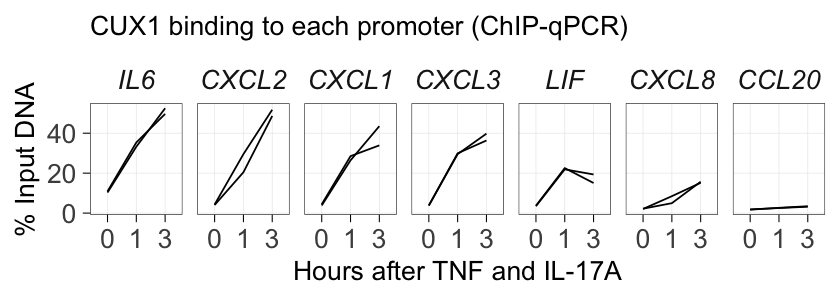

In [14]:
chip <- subset(chip, date %in% c("2017-01-03", "2018-08-22"))

chip_cux1 <- subset(chip, antibody == "CUX1")
chip_control <- subset(chip, antibody == "Control")

all(chip_cux1$promoter == chip_control$promoter)
all(chip_cux1$time == chip_control$time)

chip_cux1$ct_delta_rn <- chip_cux1$ct_delta_rn - chip_control$ct_delta_rn

chip_cux1$ddct <- 2 ^ - chip_cux1$ct_delta_rn

chip_cux1$promoter <- str_split_fixed(chip_cux1$promoter, ",", 2)[,1]

head(chip_cux1)

chip_cux1$promoter[chip_cux1$promoter == "IL8"] <- "CXCL8"

chip_cux1$promoter <- factor(chip_cux1$promoter, levels = c("IL6", "CXCL2", "CXCL1", "CXCL3", "LIF", "CXCL8", "CCL20"))


p <- ggplot(chip_cux1) +
aes(x = time, y = 100 * ddct, group = paste(promoter, replicate)) +
geom_line() +
facet_grid(~ promoter) +
scale_y_continuous(breaks = scales::pretty_breaks(3)) +
# scale_color_discrete(guide = FALSE) +
theme(
  strip.text = element_text(face = "italic", size = 16),
  plot.title = element_text(size = 16),
  plot.subtitle = element_text(size = 16),
  axis.title = element_text(size = 16),
  axis.text = element_text(size = 16)
) +
labs(
  x = "Hours after TNF and IL-17A",
  y = "% Input DNA",
  subtitle = "CUX1 binding to each promoter (ChIP-qPCR)"
)

options(repr.plot.width = 7, repr.plot.height = 2.5)

show_plot(p, name = "chip-qpcr")
# show_plot(p, res = 300)

promoter,replicate,time,fold
<fct>,<dbl>,<chr>,<dbl>
IL6,1,t1,3.226567
IL6,2,t1,3.249010
CXCL2,1,t1,5.063026
CXCL2,2,t1,6.868523
CXCL1,1,t1,6.453134
CXCL1,2,t1,6.916298


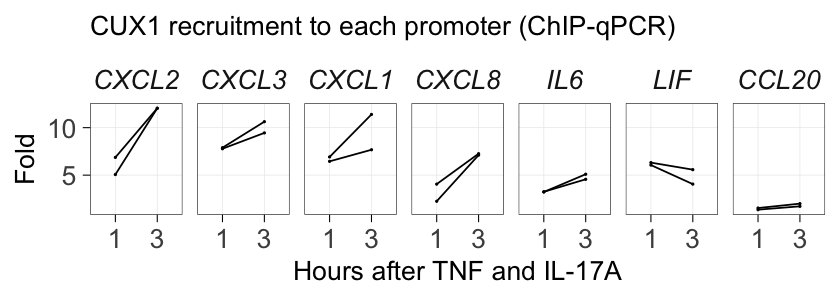

In [54]:
x <- chip_cux1 %>%
group_by(promoter, replicate) %>%
summarize(
  t1 = ddct[time == 1] / ddct[time == 0],
  t3 = ddct[time == 3] / ddct[time == 0]
)
x <- x %>% gather("time", "fold", -promoter, -replicate)
# group_by(promoter, time) %>%
# summarize(fold = mean(fold))

head(x)

x$promoter <- factor(x$promoter, levels = c("CXCL2", "CXCL3", "CXCL1", "CXCL8", "IL6", "LIF", "CCL20"))

p <- ggplot(x) +
aes(x = time, y = fold, group = paste(promoter, replicate)) +
geom_line() +
geom_point(size = 0.25) +
# geom_hline(yintercept = 1, size = 0.2) +
facet_grid(~ promoter) +
scale_y_continuous(breaks = scales::pretty_breaks(4)) +
# scale_y_continuous(breaks = c(0, 6, 12)) +
# annotation_logticks(base = 2, sides = "l") +
# scale_y_log10() +
scale_x_discrete(labels = c(1, 3)) +
# scale_color_discrete(guide = FALSE) +
theme(
#   panel.border = element_blank(),
#   panel.background = element_rect(fill = "grey93", size = 0),
#   panel.grid.major = element_line(color = "white", size = 0.5),
#   panel.grid.minor = element_line(color = "white", size = 0.25),
  strip.text = element_text(face = "italic", size = 16),
  plot.title = element_text(size = 16),
  plot.subtitle = element_text(size = 16),
  axis.title = element_text(size = 16),
  axis.text = element_text(size = 16)
) +
# theme_gray() +
labs(
  x = "Hours after TNF and IL-17A",
  y = "Fold",
  subtitle = "CUX1 recruitment to each promoter (ChIP-qPCR)"
)

options(repr.plot.width = 7, repr.plot.height = 2.5)

show_plot(p, name = "chip-qpcr-fold")

In [348]:
x <- chip_cux1 %>%
filter(promoter %in% c("CXCL2", "CXCL1", "CXCL3")) %>%
filter(time %in% c(0, 3)) %>%
mutate(after = time > 0) %>%
group_by(promoter) %>%
summarize(mean = mean(ddct[after]) / mean(ddct[!after]))

x %>% mutate_if(is.numeric, signif, 3)

x %>% 
summarize(mean(mean)) %>% mutate_if(is.numeric, signif, 3)

promoter,mean
CXCL2,12.0
CXCL1,9.4
CXCL3,10.0


mean(mean)
10.5
